In [1]:
import numpy as np
from sklearn.utils import check_random_state
from _lloyd_iter import calc_sums
import pairwise_kernel

In [2]:
class KKMeans():
    def __init__(self, n_clusters=8, init="random", n_init=1,
                 max_iter=300, tol=None, verbose=0,
                 random_state=None, algorithm="lloyd", kernel="linear", **kwargs):
        self.n_clusters = n_clusters
        self.init = init
        self.n_init = n_init
        self.max_iter = max_iter
        self.tol = tol
        self.verbose = verbose
        self.random_state = check_random_state(random_state)
        self.algorithm = algorithm
        self.kernel = kernel
        self.kwargs = kwargs
        self.labels = None
        self.distances = None
        
    def _p_kernel_wrapper(self, X, Y=None):
        return pairwise_kernel.kernel_matrix(X, Y, kernel=self.kernel, **self.kwargs)
    
    def fit(self, data):
        ''' Provides interface for user to fit data.'''
        self._check_data(data)
        
        if self.algorithm == "lloyd":
            self._lloyd(data)
        
    def _check_data(self, data):
        return
    
    def _lloyd(self, data):
        '''
        The original kkmeans algorithm.
        _init is used to assign labels.
        inertia is sum of squared distances to nearest centroid (==variance).
        each row of distances is datapoint, each column centroid,
            e.g. distances[0,0] is distance from data[0] to center of first cluster.
        From mathematical pov distances could be initialized with 0-matrix each iter,
            but too little time is saved to justify the risk of confusion,
            as the resulting inertia wouldn't be variance anymore (but still as valid)
        _lloyd_iter updates distances from each point to each centroid, by using 
            formulas from kkmeans paper.
        
        '''
        kernel_matrix = self._p_kernel_wrapper(data)
        self._init(data, kernel_matrix)
        inertia = 0
        for _ in range(self.max_iter):
            self.distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T
            self._lloyd_iter(kernel_matrix, self.distances)
            labels_new = np.argmin(self.distances, axis=1)
            inertia_new = np.amin(self.distances, axis=1).sum()
            if all(labels_new == self.labels) or abs(inertia - inertia_new) < self.tol:
                if self.verbose:
                    print("Converged at iteration:", _ + 1,
                          "Inertia:", inertia_new)
                return inertia, labels_new
            self.labels = labels_new
            inertia = inertia_new
    
    def _lloyd_iter(self, kernel_matrix, distances):
        element_sums, cluster_sums, magnitudes =\
            calc_sums(kernel_matrix, self.labels, self.n_clusters)
        
        for cluster in range(self.n_clusters):
            magn = magnitudes[cluster]
            el_sum = element_sums[:, cluster]
            cl_sum = cluster_sums[cluster]
            self.distances[:, cluster] += (cl_sum / magn**2
                                     -2 * el_sum / magn)
    
    def _init(self, data, kernel_matrix):
        '''Assign labels to each datapoint by given method'''
        if isinstance(self.init, (list, tuple, np.ndarray)):
            self._check_centroids() # TODO 
            self._assign_to_centroids(self.init, data)
            return
        
        elif self.init == "random":
            centroids = data[self.random_state.randint(0, len(data), self.n_clusters)]
            self.labels = self._assign_to_centroids(centroids, data)
            return
        
        elif self.init == "truerandom":
            self.labels = self.random_state.randint(0, self.n_clusters, len(data))
            return
        
        elif self.init == "kmeans++":
            self.labels = self._kmeanspp(data, kernel_matrix)
            return 
        
        raise Exception("Unknown initialisation method")
    
    def _check_centroids(self):
        if len(self.init) != self.n_clusters:
            raise Exception("The number of given centroids should match n_clusters") # TODO
        return

    def _assign_to_centroids(self, centroids, data):
        '''
        Calculates distances to each given center by using SQUARED distances,
        as in the feature space one cannot explicitly calculate euclidian distance
        and instead one has to rely on ||a-b||^2 == K(a,a) - 2K(a,b) + K(b,b)
        (K(.,.) is the kernel)
        (Here, K(a,a) is omitted since it is doesn't change for each datapoint)
        '''
        data_centr_kernel = self._p_kernel_wrapper(data, centroids)
        centr_distances = np.zeros((len(data), self.n_clusters))
        for cluster in range(self.n_clusters):
            centr_distances[:, cluster] = (-2 * data_centr_kernel[:, cluster]
                                        + self._p_kernel_wrapper([centroids[cluster]]))
        return np.argmin(centr_distances, axis = 1)

    
    def _kmeanspp(self, data, kernel_matrix):
        '''
        Kmeans++ with the distance described in _assign_to_centroids.
        Here, K(a,a) must NOT be omitted.
        '''
        centroids = np.zeros((self.n_clusters, len(data[0])))
        centr_distances = np.tile(np.diag(kernel_matrix), (self.n_clusters, 1)).T   
        for cluster in range(self.n_clusters):
            if cluster == 0:
                #random first center
                index = self.random_state.randint(len(data))
            else:
                max_dist_each = np.amin(centr_distances[:, :cluster + 1], axis = 1)
                max_dist_each[max_dist_each < 0] = 0 
                probs = max_dist_each/max_dist_each.sum()
                index = self.random_state.choice(len(data), size=1, p=probs)
            centroids[cluster] = data[index]
            cluster_term = self._p_kernel_wrapper([centroids[cluster]])
            data_term = self._p_kernel_wrapper(data, [centroids[cluster]])
            centr_distances[:, cluster] += (-2 * data_term + cluster_term).reshape(len(data),)    
        return np.argmin(centr_distances, axis=1)                
            
    def predict(self, data):
        return
            
            


In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles
from sklearn.cluster import KMeans

In [4]:
def visualize(data, labels):
    if len(data[0]) > 3:
        raise Exception("Dimensionality is too high for visualization")
    elif len(data[0]) == 1:
        plt.scatter(data, [0 for x in range(len(data))], c = labels)
    elif len(data[0]) == 2:
        plt.scatter(data[:,0], data[:,1], c = labels)
    elif len(data[0]) == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection = "3d")
        ax.scatter(data[:,0], data[:,1], data[:,2], c = labels)

In [13]:
x, labels, centers = make_blobs(10000, centers = 10, return_centers = True, random_state = 0, n_features = 3)

In [14]:
kkm = KKMeans(n_clusters = 10, verbose = True, init = "kmeans++", kernel = "linear", random_state = 0, tol = 1e-4)

Converged at iteration: 7 Inertia: 29314.138670604927
0.40584325790405273


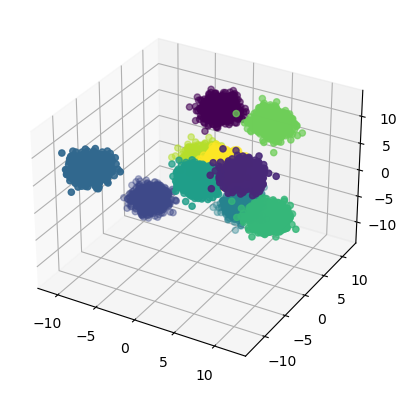

In [18]:
import time as t
start = t.time()
kkm.fit(x)
print(t.time() - start)
visualize(x, kkm.labels)